# Find anomaly using transformer

# 1. give tag using model

In [232]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from finance_byu import fama_macbeth
import warnings
import statsmodels.api as sm

In [233]:
input_seq_size = 30
output_seq_size = 1

# Hyperparameters
input_dim = input_seq_size * 31  # 特征数量
d_model = 1024
nhead = 64
num_encoder_layers = 3
dim_feedforward = 128
dropout = 0.1
seq_length = 30
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [234]:
warnings.filterwarnings('ignore')

In [235]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # 选择第一个可用的GPU
else:
    device = torch.device('cpu')  # 若GPU不可用，则选择CPU

In [236]:
class StockDataset(Dataset):
    def __init__(self, features, targets, seq_length=30):
        self.features = features
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.targets[idx + self.seq_length]
        return x, y


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, d_model))  # 500 is a max sequence length
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.embedding(src) * np.sqrt(self.d_model)
        src += self.pos_encoder[:, :src.size(1), :]
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

In [237]:
model = TransformerModel(input_dim=input_dim, d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward)
model.load_state_dict(torch.load('models/31_10_epochs.pth'))
model.to(device)

TransformerModel(
  (embedding): Linear(in_features=930, out_features=1024, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=1024, out_features=1, bias=True)
)

In [238]:
data = pd.read_feather('temp/before1.6_monthly_stock_return.feather')
data = data.dropna()

data['index'] = data.index

# change data type
data['size_tag'] = data['size_tag'].astype('float64')
data['ROE_tag'] = data['ROE_tag'].astype('float64')
data['bm_tag'] = data['bm_tag'].astype('float64')
data['INV_tag'] = data['INV_tag'].astype('float64')
data['momentum_tag'] = data['momentum_tag'].astype('float64')
data['reversal_tag'] = data['reversal_tag'].astype('float64')

feature_list = ['monthly_stock_return', 'rf', 'excess_return',
                'market_value', 'JAN', 'total_assets', 'total_shareholders_equity',
                'BM ratio', 'ROE', 'assets_increasing_rate', 'momentum', 'reversal',
                'size_tag', 'ROE_tag', 'bm_tag', 'INV_tag', 'momentum_tag',
                'reversal_tag', 'mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA',
                'JAN t+1', 'size*JAN', 'BM*JAN',
                'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN',
                'mkt_risk_premium*JAN']
scaler = StandardScaler()
mean_list = []
std_list = []
data[feature_list] = scaler.fit_transform(data[feature_list])
normalized_data = data
normalized_mean = scaler.mean_
normalized_std = scaler.scale_

In [239]:
def get_src(data, num_samples, input_seq_size):
    if len(data) - input_seq_size - output_seq_size + 1 <= 0:
        return
    src_data = np.array([data[i:i + input_seq_size] for i in range(num_samples)])
    return src_data


def get_tgt(data, num_samples, input_seq_size, output_seq_size):
    if len(data) - input_seq_size - output_seq_size + 1 <= 0:
        return
    tgt_data = np.array([data['monthly_stock_return'][i + input_seq_size:i + input_seq_size + output_seq_size] for i in range(num_samples)])
    return tgt_data

In [240]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [241]:
# normalized_data = normalized_data[(normalized_data['Stkcd'] == "000001") | (normalized_data['Stkcd'] == "000002")]

# test_data = normalized_data[normalized_data['month'] >= '2013-03-01']
test_data = normalized_data

test_data['new_factor'] = 0
test_data['new_factor'] = test_data['new_factor'].astype('float64')

src_data = test_data.groupby('Stkcd', observed=False).apply(
    lambda x: get_src(x[feature_list + ['index',]], len(x) - input_seq_size - output_seq_size + 1, input_seq_size), include_groups=False)
src_data.dropna(inplace=True)
src_data = np.concatenate(src_data)
src_data = src_data.reshape(src_data.shape[0], input_dim + input_seq_size)  # containing 30 index
src_data = torch.tensor(src_data).float().to(device)

tgt_data = test_data.groupby('Stkcd', observed=False).apply(
    lambda x: get_tgt(x[feature_list], len(x) - input_seq_size - output_seq_size + 1, input_seq_size, output_seq_size), include_groups=False)
tgt_data.dropna(inplace=True)
tgt_data = np.concatenate(tgt_data)
# tgt_data = tgt_data.reshape(tgt_data.shape[0], 32)
tgt_data = torch.tensor(tgt_data).float().to(device)

# Create DataLoader
dataset = StockDataset(src_data, tgt_data, seq_length=input_seq_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model.eval()

TransformerModel(
  (embedding): Linear(in_features=930, out_features=1024, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=1024, out_features=1, bias=True)
)

In [242]:
index_list = []
with torch.no_grad():
    total_loss = 0
    for batch in dataloader:
        x_batch, y_batch = batch
        y_batch = y_batch.float()
        index = int(x_batch[0][-1][-1])
        index_list.append(index)
        tmp = torch.zeros(1, input_seq_size, input_dim)
        for i in range(len(x_batch[0])):
            tmp[0][i] = torch.cat([x_batch[0][i][i*32:i*32+31] for i in range(input_seq_size)])
        tmp = tmp.to(device)

        output = model(tmp)
        
        result = float(output.squeeze())
        test_data.loc[index, 'new_factor'] = result
        
        loss = criterion(output.squeeze(), y_batch)
        total_loss += loss.item()
        # break
    avg_loss = total_loss / len(dataloader)
    print(f"Loss on Test set: {avg_loss:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (30x31 and 930x1024)

In [198]:
x_batch.shape

torch.Size([1, 30, 960])

In [199]:
# result, index
min(index_list)

58

In [200]:
test_data = test_data[test_data['index'].isin(index_list)]
test_data[['Stkcd', 'month', 'new_factor', 'monthly_stock_return', 'index']]

,Stkcd,month,new_factor,monthly_stock_return,index
58,000001,2005-08,NaN,0.253003,58
59,000001,2005-09,NaN,-0.569475,59
60,000001,2005-10,0.072232,-0.133800,60
61,000001,2005-11,-0.298292,0.071430,61
62,000001,2005-12,0.134010,0.258093,62
...,...,...,...,...,...
664576,900957,2023-05,0.250149,-0.276047,664576
664577,900957,2023-06,0.064995,-0.295116,664577
664578,900957,2023-07,-0.562463,0.188147,664578
664579,900957,2023-08,0.037867,-1.122319,664579


# 2. Famamacbeth and backtesting

## 2.1 Fama-MacBeth regression

In [201]:
test_data.head()

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,mkt_risk_premium*JAN,size*JAN_loading,BM*JAN_loading,ROE*JAN_loading,INV*JAN_loading,MOM*JAN_loading,REV*JAN_loading,mkt_risk_premium*JAN_loading,index,new_factor
58,000001,2005-08,0.253003,0.340985,0.251701,-0.015849,3.080962,-0.807932,-0.210898,0.002343,...,-0.069924,0.017516,0.021900,0.092573,-0.065935,0.038087,-0.002158,0.068011,58,NaN
59,000001,2005-09,-0.569475,0.236678,-0.570386,-0.032761,3.250031,-0.791173,-0.209282,0.008043,...,-0.069924,0.019735,0.021927,0.098366,-0.078334,0.043878,-0.000176,0.067519,59,NaN
60,000001,2005-10,-0.133800,0.340985,-0.135105,-0.034560,3.250031,-0.791173,-0.209137,0.008043,...,-0.069924,0.022077,0.024350,0.108572,-0.095118,0.053215,-0.001025,0.066188,60,0.072232
61,000001,2005-11,0.071430,0.236678,0.070525,-0.029882,3.250031,-0.791173,-0.209507,0.008043,...,-0.069924,0.021591,0.018005,0.113459,-0.094968,0.053191,-0.000355,0.065696,61,-0.298292
62,000001,2005-12,0.258093,0.340985,0.256792,-0.019087,3.396977,-0.787342,-0.210215,0.007425,...,2.873076,0.101894,0.015295,0.119281,-0.137167,0.027985,0.001873,0.095037,62,0.134010


In the first step, we run the cross-sectional regression:
$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{t}+\beta_{2,t}SIZE_{t}*JAN_{t+1}+\beta_{3,t}BM_{t}+\beta_{4,t}BM_{t}*JAN_{t+1}+\beta_{5,t}ROE_{t}+\beta_{6,t}ROE_{t}*JAN_{t+1}+\beta_{7,t}INV_{t}+\\ \beta_{8,t}INV_{t}*JAN_{t+1}+\beta_{9,t}MOM_{t}+\beta_{10,t}MOM_{t}*JAN_{t+1}+\beta_{11,t}REV_{t}+\beta_{12,t}REV_{t}*JAN_{t+1}+\beta_{13,t}MRKRP_{t}+\beta_{14,t}MKTRP_{t}*JAN_{t+1}+\beta_{15,t}new\_factor_{t}+e_{i,t+1}$$

Then we can get the time-series average of the coefficients:
$$\bar{\beta_i}=\frac{1}{T}\sum_{t=1}^{T}\beta_{i,t}$$

Also, we can get  Standard errors, t-statistics, and p-values calculated using the Newey and West (1987) adjustment with six lags.

In [202]:
test_data.dtypes

Stkcd                              object
month                           period[M]
monthly_stock_return              float64
rf                                float64
excess_return                     float64
market_value                      float64
total_assets                      float64
total_shareholders_equity         float64
BM ratio                          float64
ROE                               float64
assets_increasing_rate            float64
momentum                          float64
reversal                          float64
size_tag                          float64
ROE_tag                           float64
bm_tag                            float64
INV_tag                           float64
momentum_tag                      float64
reversal_tag                      float64
mkt_risk_premium                  float64
SMB                               float64
HML                               float64
RMW                               float64
CMA                               

In [203]:
test_data[feature_list] = (test_data[feature_list] + normalized_mean) * normalized_std

In [204]:
factors_list = ['month','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN', 'new_factor']

In [205]:
my_fm = fama_macbeth.fama_macbeth(test_data.loc[:,factors_list].dropna(), 'month', 't+1_excess_return', factors_list[2:])
result_my_fm = fama_macbeth.fm_summary(my_fm, pvalues=True)
result_my_fm

,mean,std_error,tstat,pval
intercept,0.006868,0.006508,1.055319,2.923107e-01
SMB,-0.000219,0.000493,-0.443221,6.579938e-01
HML,-0.000053,0.000311,-0.171192,8.642132e-01
RMW,-0.000056,0.000271,-0.205541,8.373188e-01
CMA,0.000024,0.000163,0.145863,8.841486e-01
momentum,0.001617,0.000775,2.087176,3.789753e-02
reversal,0.001723,0.000828,2.080993,3.846508e-02
mkt_risk_premium,0.001120,0.000698,1.605802,1.095951e-01
size*JAN,0.011088,0.020835,0.532194,5.950697e-01
BM*JAN,0.008481,0.015936,0.532184,5.950771e-01


## 2.2 Backtesting

In [ ]:
# test_data[test_data['new_factor'] == 0]['new_factor'] = -1
# test_data[test_data['new_factor'] == -1]['new_factor'] = 0

In [206]:
long_short = test_data.groupby(['month'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['new_factor']))

In [207]:
long_short = long_short.to_frame()
long_short.columns = ['new_factor']

In [208]:
# import and clean the risk-free rate data
rf = pd.read_excel('source_data/Risk-Free Rate/TRD_Nrrate.xlsx')  # load the risk-free rate data
rf = rf.iloc[2:, :]
rf = rf[['Clsdt', 'Nrrdaydt','Nrrdata']]
rf.columns = ['date', 'daily_rf','rf']
rf['date'] = pd.to_datetime(rf['date'])
rf['daily_rf'] = rf['daily_rf'] / 100  # change the unit of the risk-free rate to decimal
rf['rf'] = rf['rf'] / 100  # change the unit of the risk-free rate to decimal
rf['month'] = rf['date'].dt.to_period('M')
rf_monthly = rf.groupby('month').agg({'daily_rf': [lambda x: (1 + x).prod() - 1], 'rf': 'last'})
rf_monthly.reset_index(inplace=True)
rf_monthly.columns = ['month', 'monthly_rf','rf']

In [209]:
# load fama-french five factors data
factor_data = pd.read_excel(
    'source_data/5-Factor Model Index (Monthly)/STK_MKT_FIVEFACMONTH.xlsx')
factor_data = factor_data[
    ['MarkettypeID', 'TradingMonth', 'Portfolios', 'RiskPremium2', 'SMB2', 'HML2', 'RMW2', 'CMA2']]
factor_data.columns = ['MarkettypeID', 'date', 'portfolios', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']
factor_data = factor_data.iloc[2:, :]
factor_data = factor_data[factor_data['portfolios'] == 1]
factor_data = factor_data[
    factor_data['MarkettypeID'] == "P9706"]  # P9706: SSE-SZSE A share market (excluding STAR Market, ChiNext)
factor_data.reset_index(drop=True, inplace=True)  # reset the index to 0,1,2,...
factor_data = factor_data[['date', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']]
factor_data.columns = ['month', 'mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']
factor_data['month'] = pd.to_datetime(factor_data['month']).dt.to_period('M')

In [210]:
long_short['month'] = long_short.index

# merge rf and market return to long_short and long_short
long_short['rf'] = long_short['month'].map(rf_monthly.set_index('month')['monthly_rf'])
long_short['mkt_risk_premium'] = long_short['month'].map(factor_data.set_index('month')['mkt_risk_premium'])
long_short['market_return'] = long_short['mkt_risk_premium'] + long_short['rf']
long_short['new_factor'] = long_short['new_factor'] + long_short['rf']

long_short.head()

,new_factor,month,rf,mkt_risk_premium,market_return
month,,,,,
2003-03,NaN,2003-03,0.001675,-0.006907,-0.005232
2003-04,NaN,2003-04,0.001621,0.000733,0.002354
2003-05,0.034299,2003-05,0.001675,0.040669,0.042344
2003-06,-0.067796,2003-06,0.001621,-0.059786,-0.058165
2003-07,-0.025485,2003-07,0.001675,-0.011581,-0.009906


In [211]:
# long_short['new_factor'] = long_short['new_factor'] - long_short['rf']

In [219]:
long_short['temp'] = long_short['new_factor'].apply(lambda x: x if x >=-.1 else -0.1)

<Axes: xlabel='month'>

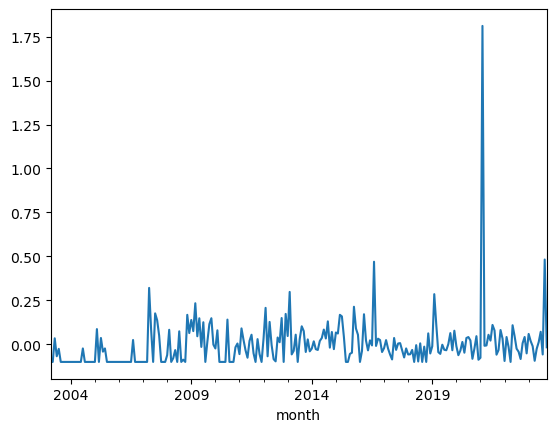

In [225]:
# np.prod(long_short['temp'] + 1) - 1
long_short['temp'].plot()
# (long_short['temp']+1).cumprod().plot()

# np.prod(long_short['new_factor'] + 1) - 1
# long_short['new_factor'].plot()

In [ ]:
test_data.to_feather('temp/test_data.feather')

# 3. figure out what anomaly it is

## 3.1 regress new_factor on various variables

In [ ]:
test_data = pd.read_feather('temp/test_data.feather')

In [226]:
monthly_data = test_data.dropna()
monthly_data.head()

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,mkt_risk_premium*JAN,size*JAN_loading,BM*JAN_loading,ROE*JAN_loading,INV*JAN_loading,MOM*JAN_loading,REV*JAN_loading,mkt_risk_premium*JAN_loading,index,new_factor
60,000001,2005-10,-0.018691,0.000201,-0.019150,7.018873e+20,1.662934e+21,7.924310e+19,160.837545,0.203581,...,-0.001454,0.022077,0.024350,0.108572,-0.095118,0.053215,-0.001025,0.066188,60,0.072232
61,000001,2005-11,0.012757,0.000140,0.012359,7.018873e+20,1.662934e+21,7.924310e+19,160.827497,0.203581,...,-0.001454,0.021591,0.018005,0.113459,-0.094968,0.053191,-0.000355,0.065696,61,-0.298292
62,000001,2005-12,0.041360,0.000201,0.040901,7.018873e+20,1.662934e+21,7.924310e+19,160.808284,0.200260,...,0.061053,0.101894,0.015295,0.119281,-0.137167,0.027985,0.001873,0.095037,62,0.134010
63,000001,2006-01,0.024192,0.000201,0.023733,7.018873e+20,1.662934e+21,7.924310e+19,160.795245,0.192047,...,-0.001454,0.100435,0.015877,0.121709,-0.113447,0.023780,0.001079,0.074014,63,-0.049418
64,000001,2006-02,0.067155,0.000017,0.066879,7.018873e+20,1.662934e+21,7.924310e+19,160.765941,0.192047,...,-0.001454,0.098062,0.013788,0.124993,-0.119494,0.022713,-0.000188,0.094289,64,-0.261592


following the paper, we will regress the new factor on the ff5 with momentum and reversal factors.

In [227]:
Y = monthly_data['new_factor']
X = monthly_data[['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'momentum_loading', 'reversal_loading', 'size_tag', 'ROE_tag', 'bm_tag', 'INV_tag', 'momentum_tag', 'reversal_tag']]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [228]:
with open(r'output/part3/lag0.html', 'w') as f:
    f.write(results.summary().as_html())

according to the results above, we can find that the cross-sectional factor values can only explain the model's output little (r-squared is 0.098), so we try to add lag items.

In [229]:
for i in range(1,32):
    monthly_data[f'SMB_lag{i}'] = monthly_data['SMB'].shift(i)
    monthly_data[f'HML_lag{i}'] = monthly_data['HML'].shift(i)
    monthly_data[f'RMW_lag{i}'] = monthly_data['RMW'].shift(i)
    monthly_data[f'CMA_lag{i}'] = monthly_data['CMA'].shift(i)
    monthly_data[f'momentum_lag{i}'] = monthly_data['momentum'].shift(i)
    monthly_data[f'reversal_lag{i}'] = monthly_data['reversal'].shift(i)
    monthly_data[f'mkt_risk_premium_lag{i}'] = monthly_data['mkt_risk_premium'].shift(i)
    monthly_data[f'mkt_loading_lag{i}'] = monthly_data['mkt_loading'].shift(i)
    monthly_data[f'SMB_loading_lag{i}'] = monthly_data['SMB_loading'].shift(i)
    monthly_data[f'HML_loading_lag{i}'] = monthly_data['HML_loading'].shift(i)
    monthly_data[f'RMW_loading_lag{i}'] = monthly_data['RMW_loading'].shift(i)
    monthly_data[f'CMA_loading_lag{i}'] = monthly_data['CMA_loading'].shift(i)
    monthly_data[f'momentum_loading_lag{i}'] = monthly_data['momentum_loading'].shift(i)
    monthly_data[f'reversal_loading_lag{i}'] = monthly_data['reversal_loading'].shift(i)
    monthly_data[f'size_tag_lag{i}'] = monthly_data['size_tag'].shift(i)
    monthly_data[f'ROE_tag_lag{i}'] = monthly_data['ROE_tag'].shift(i)
    monthly_data[f'bm_tag_lag{i}'] = monthly_data['bm_tag'].shift(i)
    monthly_data[f'INV_tag_lag{i}'] = monthly_data['INV_tag'].shift(i)
    monthly_data[f'momentum_tag_lag{i}'] = monthly_data['momentum_tag'].shift(i)
    monthly_data[f'reversal_tag_lag{i}'] = monthly_data['reversal_tag'].shift(i)

In [230]:
Y = monthly_data['new_factor'][31:]
X = monthly_data[['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium']]
for i in range(1,32):
    X = pd.concat([X, monthly_data[[f'SMB_lag{i}', f'HML_lag{i}', f'RMW_lag{i}', f'CMA_lag{i}', f'momentum_lag{i}', f'reversal_lag{i}', f'mkt_risk_premium_lag{i}', f'mkt_loading_lag{i}', f'SMB_loading_lag{i}', f'HML_loading_lag{i}', f'RMW_loading_lag{i}', f'CMA_loading_lag{i}', f'momentum_loading_lag{i}', f'reversal_loading_lag{i}', f'size_tag_lag{i}', f'ROE_tag_lag{i}', f'bm_tag_lag{i}', f'INV_tag_lag{i}', f'momentum_tag_lag{i}', f'reversal_tag_lag{i}']]], axis=1)
    # X = pd.concat([X, monthly_data[[f'SMB_lag{i}', f'HML_lag{i}', f'RMW_lag{i}', f'CMA_lag{i}', f'momentum_lag{i}', f'reversal_lag{i}', f'mkt_risk_premium_lag{i}', f'mkt_loading_lag{i}', f'SMB_loading_lag{i}', f'HML_loading_lag{i}', f'RMW_loading_lag{i}', f'CMA_loading_lag{i}', f'momentum_loading_lag{i}', f'reversal_loading_lag{i}']]], axis=1)
    # X = pd.concat([X, monthly_data[[f'SMB_lag{i}', f'HML_lag{i}', f'RMW_lag{i}', f'CMA_lag{i}', f'momentum_lag{i}', f'reversal_lag{i}', f'mkt_risk_premium_lag{i}', f'size_tag_lag{i}', f'ROE_tag_lag{i}', f'bm_tag_lag{i}', f'INV_tag_lag{i}', f'momentum_tag_lag{i}', f'reversal_tag_lag{i}']]], axis=1)
X = X.dropna()
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags':6})

with open(r'output/part3/lag31.html', 'w') as f:
    f.write(results.summary().as_html())

from the file we can find that, although it's natural for r-squired to increase as we add more variables, the adjusted r-squared keeps increasing, which means that the model is getting better. 

Also, from output/part3/temp.html we can find that the p-value of nearly all variables is less than 0.05, which means that the model is significant.

Moreover, when comparing the tag_only and loading_only (which stands for the relative factor loading and the absolute factor loading), we find that the tag_only model is better than the loading_only model, which means that the new factor is more related to the relative degree than the value themselves.

So, we can know that, the ff5 on cross-sectional level can explain the new factor little, but if we add lag items, the model will become significant. And since our model is good in backtesting, we conclude that the lag items are important in stock selection.

## 3.2 conclude from model

get the gradient of the model's output with respect to the input

![SSD way](img/SSD-sum.png)

In [ ]:
# tmp

In [ ]:
model = TransformerModel(input_dim=input_dim, d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward)
model.load_state_dict(torch.load('models/new_10_epochs.pth'))
model.to(device)

In [ ]:
# tmp.requires_grad = True
# output = model(tmp)
# model.zero_grad()
# output.backward(torch.ones_like(output))
# input_gradients = tmp.grad
# input_gradients

In [ ]:
# tmp.shape

In [ ]:
train_data = normalized_data[normalized_data['month'] < '2015-01-01']
train_data = train_data.dropna()
train_data

In [ ]:
src_data = train_data.groupby('Stkcd', observed=False).apply(
    lambda x: get_src(x[feature_list], len(x) - input_seq_size - output_seq_size + 1, input_seq_size), include_groups=False)
src_data.dropna(inplace=True)
src_data = np.concatenate(src_data)
src_data = src_data.reshape(src_data.shape[0], input_dim)
src_data = torch.tensor(src_data).float().to(device)

tgt_data = train_data.groupby('Stkcd', observed=False).apply(
    lambda x: get_tgt(x[feature_list], len(x) - input_seq_size - output_seq_size + 1, input_seq_size, output_seq_size), include_groups=False)
tgt_data.dropna(inplace=True)
tgt_data = np.concatenate(tgt_data)
tgt_data = tgt_data.reshape(tgt_data.shape[0])
tgt_data = torch.tensor(tgt_data).float().to(device)


# Create DataLoader
dataset = StockDataset(src_data, tgt_data, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# calculate the SSD
SSD_result = torch.tensor([0,]*960).float().to(device)
model.eval()
# with torch.no_grad():
for batch in dataloader:
    x_batch, y_batch = batch
    x_batch, y_batch = x_batch.float(), y_batch.float()
    # print(x_batch.shape)
    x_batch.requires_grad = True
    output = model(x_batch)
    model.zero_grad()
    output.backward(torch.ones_like(output))
    input_gradients = x_batch.grad
    SSD_result += sum(input_gradients[i][j] ** 2 for i in range(input_gradients.shape[0]) for j in range(input_gradients.shape[1]))

In [ ]:
ssd_result = SSD_result.cpu().numpy()
ssd_result = ssd_result.reshape(30, 32)
ssd_result = pd.DataFrame(ssd_result, columns=feature_list)
ssd_result

In [ ]:
def get_max_n(x):
    return x.nlargest(5).index.tolist()

ssd_result.apply(get_max_n, axis=1)